## Measuring and predicting locality of smartphone memory access from trace files
### IITGN CS612 Fall 2017 - Project Checkpoint Presentation (13 November 2017)
### Sohhom Bandyopadhyay (15510011) and Sujata Sinha (15350008)

**Based on trace files from: ** <br>
http://iotta.snia.org/tracetypes/3 (Nexus 5 Smartphone Traces) <br>
Zhou, D., Pan, W., Wang, W., & Xie, T. (2015, October). I/O characteristics of smartphone applications and their implications for eMMC design. In Workload Characterization (IISWC), 2015 IEEE International Symposium on (pp. 12-21). IEEE.



** Outline (this notebook):**
This notebook presents the code and outputs of some preliminary EDA (Exploratory Data Analysis). Sections:
 - Description of trace file format
 - Conversion and data preprocessing
 - Calculate turnaround time and hardware processing time for each access, based on timestamps
 - plots of:
    - Average request size (bytes) by type of activity
    - Average turnaround time (microseconds) by type of activity
    - Average hardware time (microseconds) by type of activity
    

** ToDo (next two weeks): ** <br>
 - measuring spatial and temporal locality
 - Machine learning classifier to predict the above

## Trace file format:
**column 0** : start address (in sectors) <br>
**column 1** : access size (in sectors) <br>
**column 2** : access size (in byte) <br>
**column 3** : access type & waiting status (3 bit number):
 - LSB: indicates read (0) or write (1)
 - MSB: indicates waiting status (0 = yes, 1 = no)
 - Middle bit: unused <br>
 (It's not represented as binary, but as integers : 0, 1, 4 and 5 )
 <br>
 
**column 4** : request generate time (generated and inserted into request queue). <br>
**column 5** : request process start time (fetched and and began processing)  <br>
**column 6** : request submit time (submitted to hardware) <br>
**column 7** : request finish time (completed, callback function invoked)  <br>

Thus, any request goes through 4 stages: push to queue -> start processing -> submit to hardware -> finish (callback)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn
%matplotlib notebook

In [2]:
data_dir = 'Trace_files'
fnames = [x for x in filter(lambda x: x.endswith('.txt'), os.listdir(os.path.join('.', data_dir)))]
workload_names = [ x for x in map(lambda x: x.split('_')[1].split('.')[0], fnames) ]

In [3]:
# a dict of dataframes, indexed by name
# example: dataset['Twitter']
dataset = {fname.split('_')[1].split('.')[0]:pd.read_csv(os.path.join(data_dir, fname), delimiter='\s+', header = None, dtype = float) for fname in fnames}

## convert unix timestamps to datetime objects
also, extract the request size

In [4]:
request_sizes = { workname:dataset[workname].iloc[:,2] for workname in workload_names }
for cindx in 4, 5, 6, 7:
    for df in dataset.values():
        df.loc[:,cindx] = df.loc[:,cindx].apply(datetime.fromtimestamp)

### Calculate durations
 ... of various processing stages

In [5]:
turnaround_time = {}
hw_time = {}
for name in workload_names:
    turnaround_time[name] = dataset[name].iloc[:,7] - dataset[name].iloc[:,4]
    turnaround_time[name] = turnaround_time[name].apply(lambda x: x.components.milliseconds*1000+x.components.microseconds)
    hw_time[name] = dataset[name].iloc[:,7] - dataset[name].iloc[:,6]
    hw_time[name] = hw_time[name].apply(lambda x: x.components.milliseconds*1000+x.components.microseconds)

### Plot averages across activities

In [6]:
avg_req_size       = {x:np.mean(request_sizes[x]) for x in workload_names}

<IPython.core.display.Javascript object>


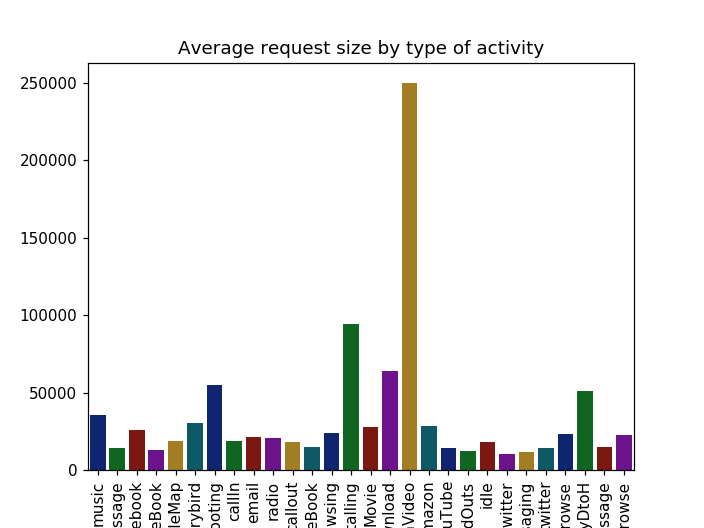

In [15]:
somevar = seaborn.barplot(list(avg_req_size.keys()), list(avg_req_size.values()), palette='dark')
for item in somevar.get_xticklabels():
    item.set_rotation(90)
plt.title("Average request size by type of activity")
plt.show()

In [8]:
avg_tat       = {x:np.mean(turnaround_time[x]) for x in workload_names}

<IPython.core.display.Javascript object>


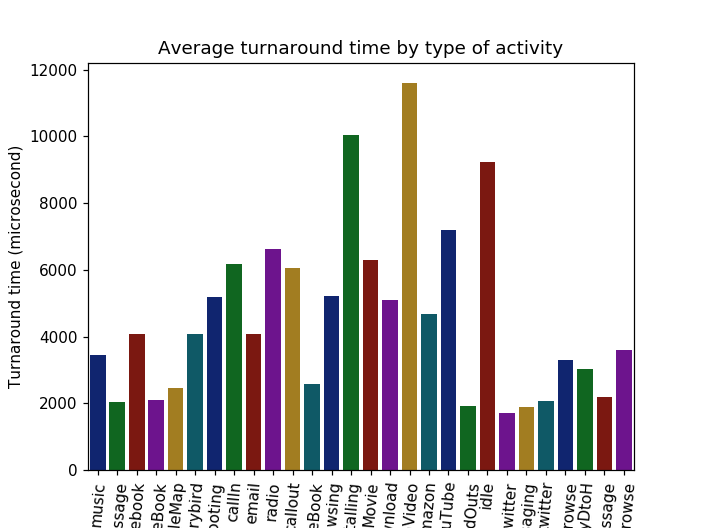

In [13]:
somevar = seaborn.barplot(list(avg_tat.keys()), list(avg_tat.values()), palette='dark')
for item in somevar.get_xticklabels():
    item.set_rotation(85)
plt.title("Average turnaround time by type of activity")
plt.xlabel('Activity')
plt.ylabel('Turnaround time (microsecond)')
plt.show()

In [10]:
avg_hw       = {x:np.mean(hw_time[x]) for x in workload_names}

<IPython.core.display.Javascript object>


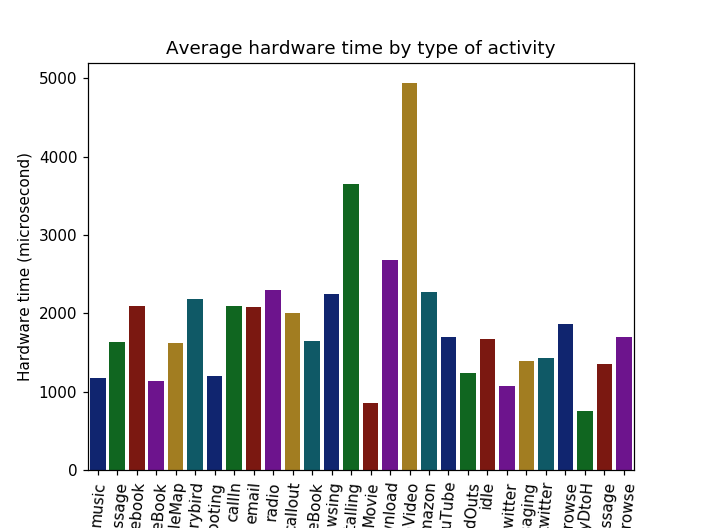

In [14]:
somevar = seaborn.barplot(list(avg_hw.keys()), list(avg_hw.values()), palette='dark')
for item in somevar.get_xticklabels():
    item.set_rotation(85)
plt.title("Average hardware time by type of activity")
plt.xlabel('Activity')
plt.ylabel('Hardware time (microsecond)')
plt.show()

## Todo

### Questions to answer:

  - How many unique sector requests?
  - How many repeated requests within a certain threshold of time (e.g. 5ms)?
  - Assuming a certain cache size and configuration, how many bytes could have been cached?
 

In [12]:
for key in dataset:
    df = dataset[key]
    print (key, ":", df.iloc[:,0].shape[0] - df.iloc[:,0].unique().shape[0], "unqiue out of", df.iloc[:,0].shape[0])

music : 2202 unqiue out of 6913
RadioMessage : 5493 unqiue out of 11101
facebook : 1334 unqiue out of 3897
MusicFaceBook : 21255 unqiue out of 35136
GoogleMap : 2772 unqiue out of 6266
angrybird : 838 unqiue out of 3215
Booting : 3630 unqiue out of 18417
callIn : 463 unqiue out of 1491
email : 1013 unqiue out of 2906
radio : 1698 unqiue out of 5820
callout : 551 unqiue out of 1569
RadioFaceBook : 5531 unqiue out of 10495
webBrowsing : 1261 unqiue out of 4090
Installing : 8901 unqiue out of 17952
Movie : 82 unqiue out of 4781
download : 6027 unqiue out of 11670
cameraVideo : 1524 unqiue out of 9348
Amazon : 1053 unqiue out of 3173
YouTube : 340 unqiue out of 2080
FaceBookHandOuts : 8430 unqiue out of 15601
idle : 2374 unqiue out of 6932
MusicTwitter : 19001 unqiue out of 30057
Messaging : 2897 unqiue out of 5702
twitter : 7304 unqiue out of 13807
RadioWebBrowse : 3417 unqiue out of 11997
copyDtoH : 1342 unqiue out of 79065
MusicMessage : 8887 unqiue out of 16504
MusicWebBrowse : 5071 un

### towards locality..
For a given workload, for each sector that was requested **more than once**, what are the **time-deltas between first request and subsequent requests?**